In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import display, clear_output
import yfinance as yf
from torch import optim
from dataclasses import dataclass

In [2]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class Model(nn.Module):

    # FITS: Frequency Interpolation Time Series Forecasting

    def __init__(self, configs):
        super(Model, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.individual = configs.individual
        self.channels = configs.enc_in

        self.dominance_freq=configs.cut_freq # 720/24
        self.length_ratio = (self.seq_len + self.pred_len)/self.seq_len

        if self.individual:
            self.freq_upsampler = nn.ModuleList()
            for i in range(self.channels):
                self.freq_upsampler.append(nn.Linear(self.dominance_freq, int(self.dominance_freq*self.length_ratio)).to(torch.cfloat))

        else:
            self.freq_upsampler = nn.Linear(self.dominance_freq, int(self.dominance_freq*self.length_ratio)).to(torch.cfloat) # complex layer for frequency upcampling]
        # configs.pred_len=configs.seq_len+configs.pred_len
        # #self.Dlinear=DLinear.Model(configs)
        # configs.pred_len=self.pred_len


    def forward(self, x):
        # RIN
        x_mean = torch.mean(x, dim=1, keepdim=True)
        x = x - x_mean
        x_var=torch.var(x, dim=1, keepdim=True)+ 1e-5
        # print(x_var)
        x = x / torch.sqrt(x_var)

        low_specx = torch.fft.rfft(x, dim=1)
        low_specx[:,self.dominance_freq:]=0 # LPF
        low_specx = low_specx[:,0:self.dominance_freq,:] # LPF
        # print(low_specx.permute(0,2,1))
        if self.individual:
            low_specxy_ = torch.zeros([low_specx.size(0),int(self.dominance_freq*self.length_ratio),low_specx.size(2)],dtype=low_specx.dtype).to(low_specx.device)
            for i in range(self.channels):
                low_specxy_[:,:,i]=self.freq_upsampler[i](low_specx[:,:,i].permute(0,1)).permute(0,1)
        else:
            low_specxy_ = self.freq_upsampler(low_specx.permute(0,2,1)).permute(0,2,1)
        # print(low_specxy_)
        low_specxy = torch.zeros([low_specxy_.size(0),int((self.seq_len+self.pred_len)/2+1),low_specxy_.size(2)],dtype=low_specxy_.dtype).to(low_specxy_.device)
        low_specxy[:,0:low_specxy_.size(1),:]=low_specxy_ # zero padding
        low_xy=torch.fft.irfft(low_specxy, dim=1)
        low_xy=low_xy * self.length_ratio # compemsate the length change
        # dom_x=x-low_x
        
        # dom_xy=self.Dlinear(dom_x)
        # xy=(low_xy+dom_xy) * torch.sqrt(x_var) +x_mean # REVERSE RIN
        xy=(low_xy) * torch.sqrt(x_var) +x_mean
        return xy, low_xy* torch.sqrt(x_var)



c:\Users\nicho\miniconda3\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\nicho\miniconda3\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  2 of 2 completed


Price      Adj Close                Close                  High              \
Ticker          AAPL        SPY      AAPL         SPY      AAPL         SPY   
Date                                                                          
2008-03-25  4.262629  99.437332  5.035000  134.850006  5.110714  135.550003   
2008-03-26  4.385990  98.220619  5.180714  133.199997  5.205000  135.089996   
2008-03-27  4.240556  97.910942  5.008929  132.779999  5.189643  134.440002   
2008-03-28  4.324007  96.974464  5.107500  131.509995  5.166071  133.360001   
2008-03-31  4.338823  97.313652  5.125000  131.970001  5.203929  132.729996   

Price            Low                  Open                  Volume             
Ticker          AAPL         SPY      AAPL         SPY        AAPL        SPY  
Date                                                                           
2008-03-25  4.904643  133.770004  4.998571  134.860001  1052391200  192947200  
2008-03-26  5.022857  133.110001  5.031071  134

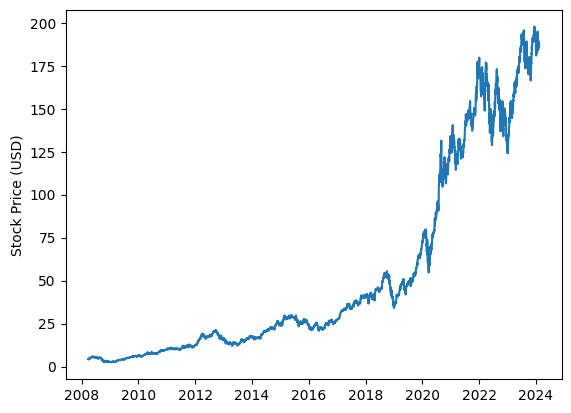

In [3]:
data = yf.download("SPY AAPL", period="4000d", interval="1d")
data.to_csv('SPY_AAPL_data.csv', index=False)
print(data.head())

y = data["Adj Close"]["AAPL"].values
y = y[:4000]
dates = data.index[:4000]
plt.ylabel('Stock Price (USD)')
plt.plot(dates, y)
plt.show()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpu = torch.cuda.get_device_properties(device).name
print(f'Using device: {gpu} with {device} support.')

seq_len = 1200
pred_len = 400
total_len = seq_len + pred_len
@dataclass
class Config:
    seq_len: int = seq_len
    pred_len: int = pred_len
    individual: bool = False
    enc_in: int = 1
    cut_freq: int = 50

model = Model(Config())
for param in model.parameters():
    param.data.fill_(0)

model_optim = optim.Adam(model.parameters(),lr=1e-4)
criterion = nn.MSELoss()

Using device: NVIDIA GeForce RTX 4070 with cuda support.


c:\Users\nicho\miniconda3\Lib\site-packages\torch\nn\modules\module.py:1148: UserWarning: Complex modules are a new feature under active development whose design may change, and some modules might not work as expected when using complex tensors as parameters or buffers. Please file an issue at https://github.com/pytorch/pytorch/issues/new?template=bug-report.yml if a complex module does not work as expected.
  warnings.warn(


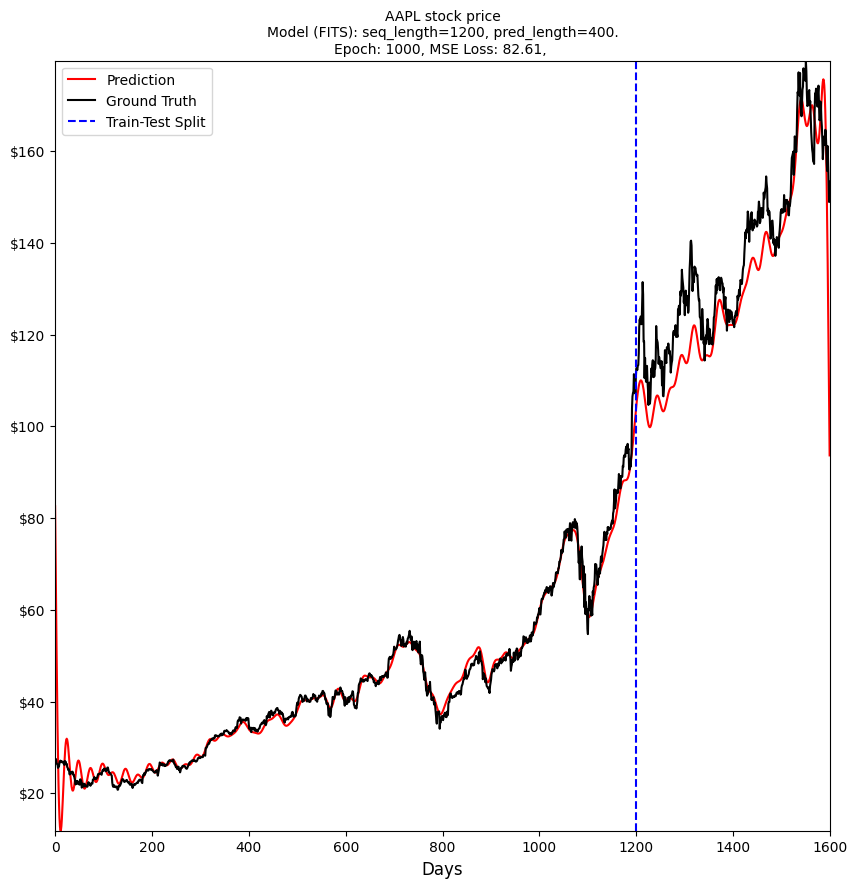

In [5]:
from matplotlib.ticker import FuncFormatter

def train(model, criterion, model_optim, y, total_len, seq_len, pred_len):
    epochs = 1001
    train_loss = []

    fig, ax = plt.subplots(figsize=(10, 10))
    line1, = ax.plot([], [], color='red', label="Prediction")
    line2, = ax.plot([], [], color='black', label="Ground Truth")
    train_test_split_line = ax.axvline(seq_len, color='blue', linestyle='--', label="Train-Test Split")
    ax.legend()
    ax.set_xlabel('Days', fontsize=12)  # Label for the y-axis
    # ax.set_ylabel('AAPL stock price (USD)', fontsize=12)  # Label for the x-axis

    text = ax.text(0.5, 1.01, "", transform=ax.transAxes, ha="center")

    # format y-axis with a dollar sign
    formatter = FuncFormatter(lambda y, _: '${:,.0f}'.format(y))
    ax.yaxis.set_major_formatter(formatter)

    for epoch in range(epochs):
        order = np.arange(2000)

        batch_losses = []

        for batch in range(25):
            batch_start = order[batch*80:(batch+1)*80]
            batch = []
            for i in batch_start:
                batch.append(y[i:i+total_len])
            batch_xy = np.array(batch).reshape(80, total_len, 1)
            batch_xy = torch.from_numpy(batch_xy).float() 

            batch_x = batch_xy[:, :seq_len, :]
            batch_y = batch_xy[:, seq_len:, :]

            model_optim.zero_grad()

            output, _ = model(batch_x)

            loss = criterion(output, batch_xy)

            batch_losses.append(loss.item())

            loss.backward()

            model_optim.step()

        epoch_loss = np.mean(batch_losses)
        train_loss.append(epoch_loss)

        output_np = output.cpu().detach().numpy()[0, :, 0]
        batch_xy_np = batch_xy.cpu().detach().numpy()[0, :, 0]
        line1.set_data(np.arange(output_np.shape[0]), output_np)
        line2.set_data(np.arange(batch_xy_np.shape[0]), batch_xy_np)
        text.set_text(f'AAPL stock price\nModel (FITS): seq_length={seq_len}, pred_length={pred_len}.\nEpoch: {epoch}, MSE Loss: {np.mean(train_loss):.2f}, ')
        

        # Adjust limits and redraw
        ax.set_xlim(0, len(output_np))
        ax.set_ylim(min(output_np.min(), batch_xy_np.min()), max(output_np.max(), batch_xy_np.max()))
        
        # Instead of clear_output and plt.show
        display(fig)
        clear_output(wait=True)

train(model, criterion, model_optim, y, total_len, seq_len, pred_len)
